# Building a Par Curve in Curvy-CUSIPs

In [1]:
import sys
sys.path.append("../")

In [23]:
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.CurveInterpolator import GeneralCurveInterpolator
from CurvyCUSIPs.USTs import USTs
from CurvyCUSIPs.utils.ust_viz import plot_usts

from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'x-large',
        'figure.figsize': (18, 10),
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
curve_data_fetcher = CurveDataFetcher(fred_api_key=config["FRED_API_KEY"])

In [4]:
usts = USTs(
    cusip_set_db_path=r"..\db\ust_cusip_set",
    cusip_timeseries_db_path=r"..\db\ust_cusip_timeseries",
    ct_eod_db_path=r"..\db\ust_eod_ct_yields",
    curve_data_fetcher=curve_data_fetcher,
)

In [19]:
as_of_date = datetime(2024, 12, 4) 

curve_set_df = usts.fetch_historical_curve_sets(
    start_date=as_of_date,
    end_date=as_of_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
)[as_of_date]

curve_set_df

AGGREGATING CURVE SET DFs: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s]


,cusip,security_type,auction_date,issue_date,maturity_date,price_per100,allocation_pctage,avg_med_yield,bid_to_cover_ratio,comp_accepted,...,percentOutstanding,est_outstanding_amt,corpus_cusip_right,outstanding_amt,portion_unstripped_amt,portion_stripped_amt,reconstituted_amt,time_to_maturity,rank,free_float
0,912797LF2,Bill,2024-09-03,2024-09-05,2024-12-05,98.743694,18.520000,null,2.620000,73568807100,...,0.007245,2.276364e+14,None,NaN,NaN,0.000000e+00,NaN,0.002740,19,2.276347e+08
1,912797MN4,Bill,2024-11-07,2024-11-12,2024-12-10,99.648833,20.190000,null,2.630000,88700873600,...,0.003045,2.457342e+14,None,NaN,NaN,0.000000e+00,NaN,0.016438,16,2.457334e+08
2,912797LP0,Bill,2024-09-09,2024-09-12,2024-12-12,98.762653,37.150000,null,3.220000,73310628000,...,0.010720,2.284207e+14,None,NaN,NaN,0.000000e+00,NaN,0.021918,18,2.284183e+08
3,912797MP9,Bill,2024-11-14,2024-11-19,2024-12-17,99.649222,95.020000,null,2.770000,88394442900,...,0.003034,2.457042e+14,None,NaN,NaN,0.000000e+00,NaN,0.035616,15,2.457035e+08
4,912797LQ8,Bill,2024-09-16,2024-09-19,2024-12-19,98.799306,86.170000,null,2.610000,73418977000,...,0.002645,2.265776e+14,None,NaN,NaN,0.000000e+00,NaN,0.041096,17,2.265770e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,108.773246,25.590000,4.160000,2.370000,20966180200,...,0.006874,6.644364e+13,912803GW7,66443644.6,55436265.5,1.100738e+10,1644240.0,28.967123,4,6.643218e+07
391,912810TX6,Bond,2024-04-11,2024-04-15,2054-02-15,93.249005,58.230000,4.608000,2.370000,21977492400,...,0.031064,7.119879e+13,912803GY3,71198791.3,55397763.4,1.580103e+10,418557.0,29.219178,3,7.118078e+07
392,912810UA4,Bond,2024-07-11,2024-07-15,2054-05-15,103.622071,88.800000,4.327000,2.300000,21966950000,...,0.097202,7.642080e+13,912803HB2,76420803.5,66329682.8,1.009112e+10,1093800.0,29.463014,2,7.640328e+07
393,912810UC0,Bond,2024-10-10,2024-10-15,2054-08-15,97.689969,14.830000,4.320000,2.500000,21973803500,...,0.070914,7.426681e+13,912803HD8,74266805.2,63461282.4,1.080552e+10,649940.0,29.715068,1,7.425073e+07


In [20]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):
    # remove OTRs, olds, double olds, triple olds
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1) & (curve_set_df["rank"] != 2) & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["security_type"] != "Bill"]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["free_float"] > 5000]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["time_to_maturity"] > 30 / 360]

    # CTDs as of Dec 5 2024
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                usts.cme_ust_label_to_cusip("4 3/8 12/15/2026")["cusip"],  # TU
                usts.cme_ust_label_to_cusip("3 7/8 12/31/2027")["cusip"],  # Z3N
                usts.cme_ust_label_to_cusip("4 1/2 5/31/2029")["cusip"],  # FV
                usts.cme_ust_label_to_cusip("4 1/8 11/30/2031")["cusip"],  # TY
                usts.cme_ust_label_to_cusip("3 7/8 8/15/2034")["cusip"],  # TN
                usts.cme_ust_label_to_cusip("4 3/8 5/15/2040")["cusip"],  # US
                usts.cme_ust_label_to_cusip("4 5/8 5/15/2044")["cusip"],  # TWE
                usts.cme_ust_label_to_cusip("4 11/15/2052")["cusip"],  # UL
            ]
        )
    ]

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])
    return curve_set_filtered_df

In [36]:
# filter and fit bspline w/ knots are liquidity points
curve_set_filtered_df = liquidity_premium_curve_set_filter(curve_set_df=curve_set_df)

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df["eod_yield"].to_numpy(),
)

fitted_bspline_k3 = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)

fitted_bspline_k5 = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 5, 7, 10, 11, 12, 13, 14, 15, 20],
    k=5,
    return_func=True,
)

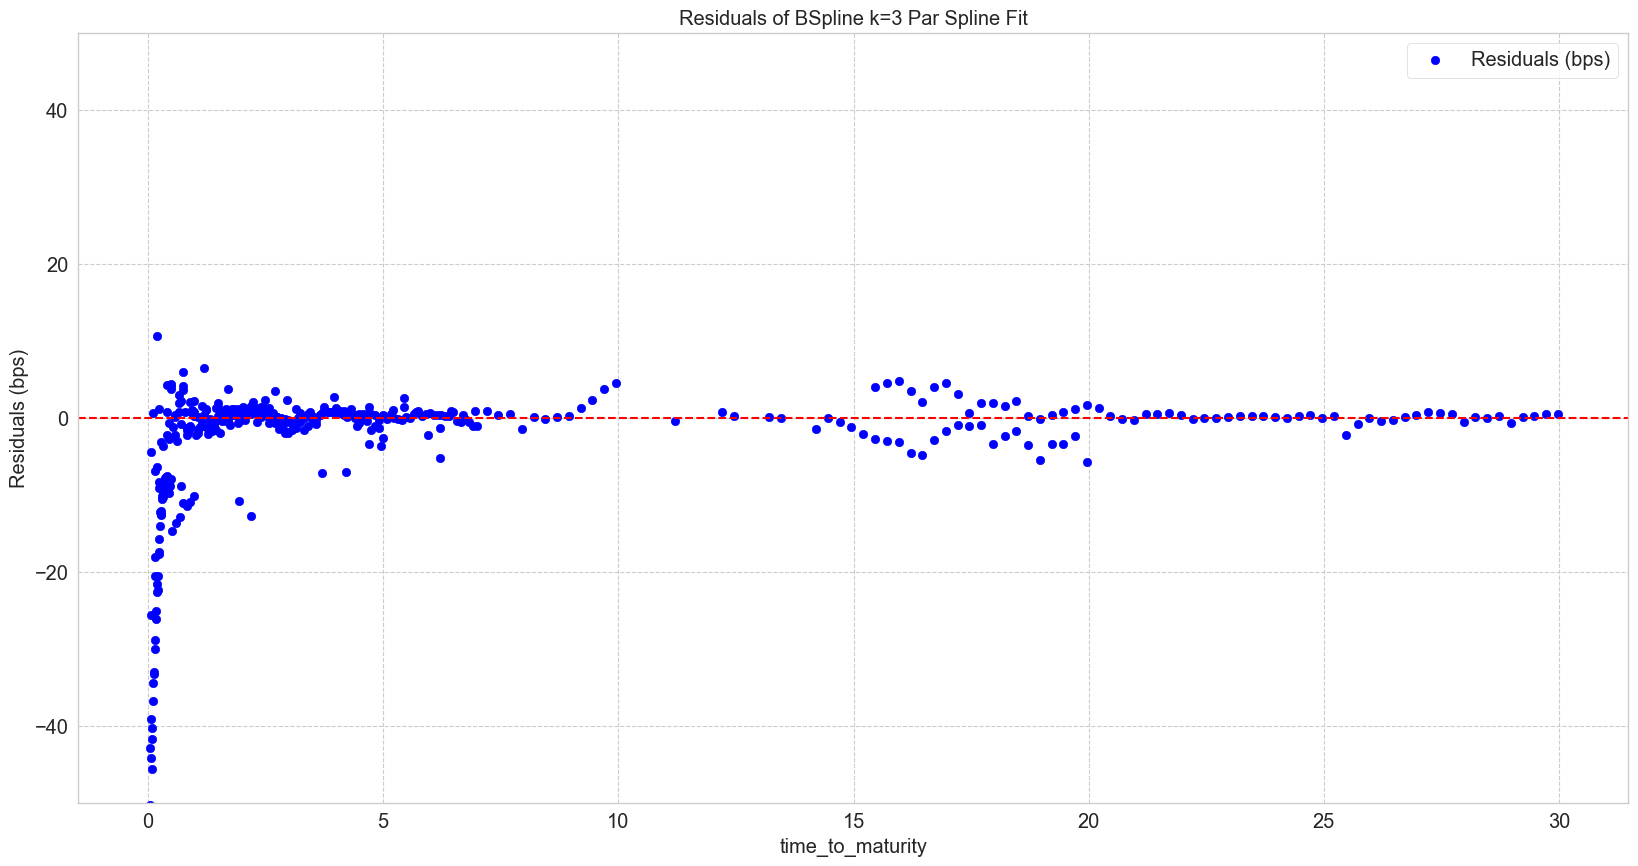

In [37]:
plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"eod_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"eod_price",
        "free_float",
    ],
    par_curves=[(fitted_bspline_k3, "BSpline k=3 Par"), (fitted_bspline_k5, "BSpline k=5 Par")],
    plot_par_model_residuals=True,
    title=f"US Treasury Market: All Active CUSIPS: {as_of_date}"
)